# Sensitivity Analysis of Ridge Regression using DiffOpt.jl

- This notebook illustrates sensitivity analysis of data points in a ridge regression problem. 

$$
\begin{split}
\begin{array} {ll}
\mbox{minimize} & \sum_{i=1}^{N} (y_{i} - w x_{i} - b)^2 + \alpha (w^2 + b^2) \\
\end{array}
\end{split}
$$
where
- $w$, $b$ are slope and intercept of the regressing line
- $x$, $y$ are the N data points
- $\alpha$ is regularization constant

## Define and solve

In [24]:
import Random
import OSQP
import Plots
using DiffOpt
using JuMP
using LinearAlgebra

In [37]:
function createProblem(N=100)
    m = 2*abs(randn())
    b = rand()
    X = randn(N)
    Y = m*X .+ b + 0.8*randn(N)
    
    return X, Y
end

X, Y = createProblem();

In [38]:
function fitRidge(X,Y,alpha=0.1)
    model = Model(() -> diff_optimizer(OSQP.Optimizer))

    # add variables
    @variable(model, w)
    @variable(model, b)
    set_optimizer_attribute(model, MOI.Silent(), true)
    
    @objective(
        model,
        Min,
        sum((Y - w*X .- b).*(Y - w*X .- b)) + alpha*(sum(w*w)+sum(b*b)),
    )

    optimize!(model)

    loss = objective_value(model)
    return model, w, b, loss, value(w), value(b)
end

fitRidge (generic function with 2 methods)

In [39]:
model, w, b, loss_train, ŵ, b̂ = fitRidge(X, Y)

(A JuMP Model
Minimization problem with:
Variables: 2
Objective function type: GenericQuadExpr{Float64,VariableRef}
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: OSQP
Names registered in the model: b, w, w, b, 54.10139386184565, 0.5530505849887637, 0.1755180508833014)

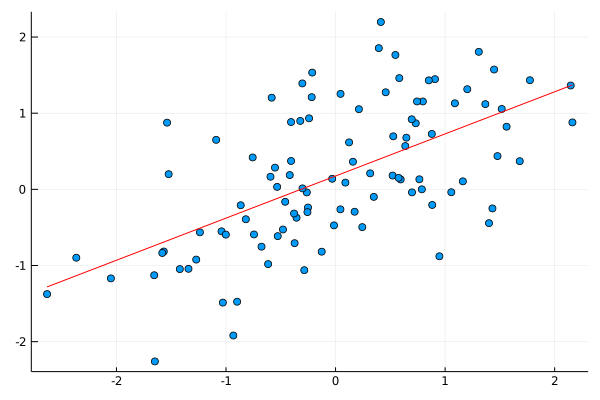

In [40]:
p = Plots.scatter(X, Y, label="")
mi, ma = minimum(X), maximum(X)
Plots.plot!(p, [mi, ma], [mi*ŵ+b̂, ma*ŵ+b̂], color=:red, label="")

## Part 2: Differentiate wrt each data point

In [49]:
∇ = zero(X)

for i in 1:length(X)
    MOI.set(
        model,
        DiffOpt.ForwardIn{DiffOpt.LinearObjective}(), 
        w, 
        -2*(Y[i] + X[i])
    ) 
    MOI.set(
        model, 
        DiffOpt.ForwardIn{DiffOpt.QuadraticObjective}(), 
        w,
        w,
        2*X[i]
    )
    
    DiffOpt.forward(model)

    db = MOI.get(
        model,
        DiffOpt.ForwardOut{MOI.VariablePrimal}(), 
        b
    )

    ∇[i] = db
end
normalize!(∇);

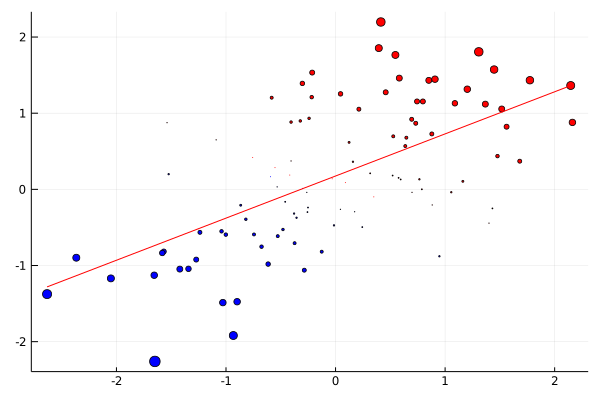

In [50]:
p = Plots.scatter(
    X, Y,
    color=[x>0 ? :red : :blue for x in ∇],
    markersize=[25*abs(x) for x in ∇],
    label=""
)
mi, ma = minimum(X), maximum(X)
Plots.plot!(p, [mi, ma], [mi*ŵ+b̂, ma*ŵ+b̂], color=:red, label="")